In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy
import warnings
warnings.filterwarnings('ignore')

In [2]:
df=pd.read_csv('Data/combined.csv')
new_index=df['Player']
df.index=new_index
df.rename(columns={'Weekly':'Wages'},inplace=True)
df.columns

Index(['Unnamed: 0', 'Player', 'Wages', 'Pos', 'MP', 'Starts', 'Min', '90s',
       'Gls', 'Ast', 'xG', 'xA', 'Sh', 'SoT', 'G/Sh', 'G/SoT', 'Dist', 'FK',
       'PK', 'G-xG', 'SCA90', 'GCA90', 'Cmp', 'Att', 'TotDist', 'PrgDist',
       'S.Cmp', 'S.Att', 'M.Cmp', 'M.Att', 'L.Cmp', 'L.Att', 'KP', '1/3',
       'PPA', 'CrsPA', 'Prog', 'PressPass', 'Cross', 'TchDefP', 'TchDef3',
       'TchMid3', 'TchAtt3', 'TchAttP', 'DrSucc', 'DrPast', 'ProgCrr',
       'Crr1/3', 'CPA', 'Tkl', 'TklW', 'TklDef3', 'TklMid3', 'TklAtt3',
       'Press', 'Succ', 'PrsDef3', 'PrsMid3', 'PrsAtt3', 'Blocks', 'Int',
       'Clr', 'Squad', 'Recov', 'ArDuWon%', 'PrgPassDist'],
      dtype='object')

From the exploratory data anlaysis, we concluded that only a few indicators will be used to model the wages. Other performance-related columns are dropped. The total minutes played and no of minutes played are retained. Age could also influence the wage. However, that will be incorporated leter.

In [3]:
df.drop(['Unnamed: 0', 'Player','MP', 
       'Gls', 'Ast', 'G/Sh', 'G/SoT', 'Dist', 'FK',
       'PK', 'G-xG','Cmp', 'Att', 'TotDist', 'PrgDist',
       'S.Cmp', 'S.Att', 'M.Cmp', 'M.Att', 'L.Cmp', 'L.Att',
        'CrsPA','PressPass', 'Cross', 'TchDefP', 'TchDef3',
       'TchMid3', 'TchAtt3', 'TchAttP', 'DrSucc', 'DrPast', 
       'Tkl', 'TklW', 'TklDef3', 'TklMid3', 'TklAtt3',
       'Press', 'Succ', 'PrsDef3', 'PrsMid3', 'PrsAtt3', 'Blocks', 'Int',
       'Clr', 'Recov', 'ArDuWon%', 'PrgPassDist'],axis=1,inplace=True)
df.rename(columns={'1/3':'Pto3','Crr1/3':'Crrto3'},inplace=True)
df.head()

,Wages,Pos,Starts,Min,90s,xG,xA,Sh,SoT,SCA90,GCA90,KP,Pto3,PPA,Prog,ProgCrr,Crrto3,CPA,Squad
Player,,,,,,,,,,,,,,,,,,,
Aaron Cresswell,50000,DF,21,1860,20.7,0.03,0.11,0.58,0.10,1.98,0.24,1.35,3.96,0.87,5.65,3.38,1.64,0.05,WHU
Aaron Lennon,10577,MFFW,11,983,10.9,0.06,0.03,0.64,0.18,1.74,0.37,0.37,0.55,0.28,1.01,2.57,0.83,0.92,BUR
Aaron Ramsdale,71154,GK,22,1980,22.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.91,0.00,0.00,0.00,0.00,0.00,ARS
Aaron Wan-Bissaka,90000,DF,18,1613,17.9,0.01,0.05,0.22,0.06,1.73,0.06,0.78,2.07,0.67,2.68,4.92,1.79,0.22,MUN
Abdoulaye Doucouré,75000,MF,18,1594,17.7,0.11,0.08,1.36,0.34,2.20,0.34,0.79,3.22,0.79,3.50,3.16,1.24,0.28,EVE


Defenders and goalkeeper are dropped as we base our model purely on attacking performance. Nevertheless, there are defenders who contribute heavily in the attacking phase for many teams. Players who have not clocked atleast 450 minutes on the pitch (equivalent to 5 matches) are also dropped.

In [4]:
df.drop(df.index[df['Pos']=='GK'],inplace=True)
df.drop(df.index[df['Pos']=='DF'],inplace=True)
df.drop(df.index[df['90s']<5],inplace=True)
df['Pos'].unique()

array(['MFFW', 'MF', 'FW', 'FWMF', 'MFDF', 'DFMF', 'FWDF'], dtype=object)

Wage outliers have to be dropped, unless their performace indicators aren't outliers too (Exceptional performance deserves exceptional wages). To find performance ouutliers, a crude measurement, that is the sum of the all performance indicators, is used.

In [5]:
upper_bound_wage=2.5*df['Wages'].quantile(0.75)-1.5*df['Wages'].quantile(0.25)
wage_outliers=set(df.index[df.Wages>upper_bound_wage])

df['Performance']=df.xG+df.xA+df.Sh+df.SoT+df.SCA90+df.GCA90+df.KP+df.Pto3+df.PPA+df.Prog+df.ProgCrr+df.Crrto3+df.CPA
upper_bound_perf=2.5*df['Performance'].quantile(0.75)-1.5*df['Performance'].quantile(0.25)
perf_outliers=set(df.index[df.Performance>upper_bound_perf])

sdf=df.drop(wage_outliers.difference(perf_outliers))
sdf.drop('Performance',axis=1,inplace=True)

We noticed in the earlier analysis that salary varies for different positions so this information is retained. The position feature is converted to dummy variables.

In [6]:
sdf=pd.concat([sdf,pd.get_dummies(sdf['Pos'])], axis=1)
sdf.drop('Pos',axis=1,inplace=True)
sdf.rename(columns={'SCA90':'SCA','GCA90':'GCA','Pto3':'Ps3','Prog':'PrP','ProgCrr':'PrC','Crrto3':'Cr3'},inplace=True)
sdf.head()

,Wages,Starts,Min,90s,xG,xA,Sh,SoT,SCA,GCA,...,Cr3,CPA,Squad,DFMF,FW,FWDF,FWMF,MF,MFDF,MFFW
Player,,,,,,,,,,,,,,,,,,,,,
Aaron Lennon,10577,11,983,10.9,0.06,0.03,0.64,0.18,1.74,0.37,...,0.83,0.92,BUR,0,0,0,0,0,0,1
Abdoulaye Doucouré,75000,18,1594,17.7,0.11,0.08,1.36,0.34,2.20,0.34,...,1.24,0.28,EVE,0,0,0,0,1,0,0
Adam Armstrong,47885,14,1216,13.5,0.30,0.13,3.26,1.04,1.92,0.22,...,1.26,1.19,SOU,0,1,0,0,0,0,0
Adam Forshaw,20000,14,1260,14.0,0.02,0.08,0.86,0.29,1.71,0.07,...,0.93,0.07,LEE,0,0,0,0,1,0,0
Adam Idah,5000,6,625,6.9,0.29,0.09,2.03,0.58,1.73,0.14,...,0.43,0.29,NOR,0,0,0,1,0,0,0


# Gradient Boost Regression

We have already established the approximate relation between some of the performance indicators and wages. We will use the same features to train the gradient boosting regression.

- xG
- xA
- Shots
- Shots on target
- Shot creating actions
- Goal creating actions
- Key passes 
- Passes to final third
- Passes to opposition box
- Progressive passes
- Progressive carries
- Carries to final third
- Carries to opposition box

Gradient boosting regression is not as sensitive as multiple regression to magnitude of the features. Therefore, we do not perform feature scaling.

In [7]:
X_train = sdf[['xG','xA','Sh','SoT','SCA','GCA','KP','Ps3','PPA','PrP','PrC','Cr3','CPA']]
Y = sdf[['Wages']]

In [8]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

In [9]:
GBR=GradientBoostingRegressor()
parameters={'n_estimators':[10,25,50,100,200],
           'max_depth':[3,5,7],
           'learning_rate':[0.01,0.05,0.1,0.2,0.5]}
GBRcv=GridSearchCV(GBR,parameters,cv=5)

In [10]:
GBRcv.fit(X_train,Y)

GridSearchCV(cv=5, estimator=GradientBoostingRegressor(),
             param_grid={'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.5],
                         'max_depth': [3, 5, 7],
                         'n_estimators': [10, 25, 50, 100, 200]})

In [11]:
GBRcv.best_estimator_

GradientBoostingRegressor(learning_rate=0.05, n_estimators=50)

In [14]:
WageModel = GradientBoostingRegressor(learning_rate=0.05,n_estimators=50)
WageModel.fit(X_train,Y)
WageModel.score(X_train,Y)

0.6902042865949006

The gradient boosting regressor has performed much better than the multiple regression.
We shall now look at the same statistics which were analyzed in the regression model.

# Post-modelling analysis

In [16]:
df.rename(columns={'SCA90':'SCA','GCA90':'GCA','Pto3':'Ps3','Prog':'PrP','ProgCrr':'PrC','Crrto3':'Cr3'},inplace=True)
X_att=df[['xG','xA','Sh','SoT','SCA','GCA','KP','Ps3','PPA','PrP','PrC','Cr3','CPA']]
df['ReasWage'] = WageModel.predict(X_att)

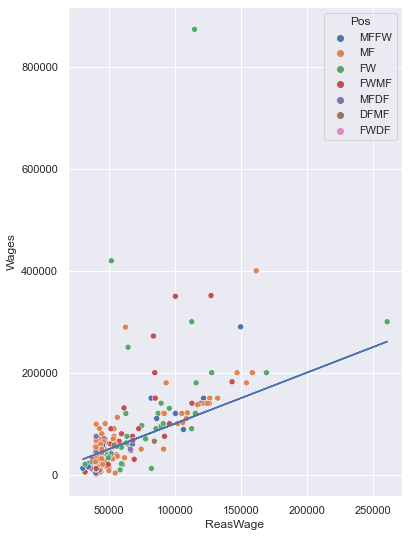

In [17]:
sns.set_theme()
plt.figure(figsize=(6,9))
sns.scatterplot(x=df.ReasWage,y=df.Wages,hue=df.Pos)
plt.plot(df.ReasWage,df.ReasWage)
#plt.fill_between(wagedf.ReasWage,0.75*wagedf.ReasWage,1.5*wagedf.ReasWage,alpha=0.1,color='red')

In [18]:
print('Wage greater than reasonable wage \t:',len(df.index[df.Wages>df.ReasWage]))
print('Wage equal to reasonable wage \t\t:',len(df.index[df.Wages==df.ReasWage]))
print('Wage less than reasonable wage \t\t:',len(df.index[df.Wages<df.ReasWage]))

Wage greater than reasonable wage 	: 95
Wage equal to reasonable wage 		: 0
Wage less than reasonable wage 		: 99


In [19]:
df['WageDiff']=(df['Wages']-df['ReasWage'])/df.ReasWage*100
print('Average difference in wage \t:',int(df['WageDiff'].mean()),'%')
print('Standard deviation \t\t:',int(df['WageDiff'].std()),'%')

Average difference in wage 	: 8 %
Standard deviation 		: 97 %


Although the average difference is less, the variance is too large.

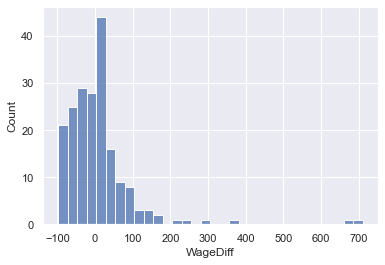

In [20]:
sns.histplot(data=df,x='WageDiff')

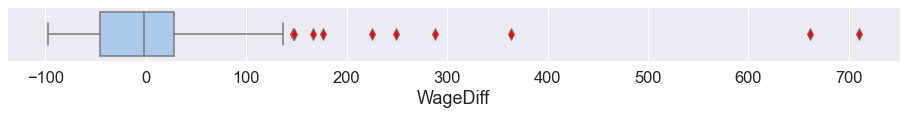

In [21]:
sns.set(rc={"figure.figsize":(16, 1)},font_scale=1.5)
ax=sns.boxplot(x='WageDiff',data=df,palette='pastel',flierprops=dict(markerfacecolor='red',markersize=8))

This model gives a more accurate description of the ground truth. The upper bound of normal wage range is only marginally greater than double the reasonable wage.

In [22]:
percentile75=df['WageDiff'].quantile(0.75)
percentile25=df['WageDiff'].quantile(0.25)
upper_bound_wage=percentile75+1.5*(percentile75-percentile25)
wage_outliers=df[df.WageDiff>upper_bound_wage]
n_outliers=wage_outliers.shape[0]
wage_outliers[["WageDiff","Squad"]].sort_values(by='WageDiff',ascending=False)

,WageDiff,Squad
Player,,
Romelu Lukaku,710.479917,CHE
Cristiano Ronaldo,661.457090,MUN
N'Golo Kanté,363.420192,CHE
Edinson Cavani,288.225537,MUN
Jadon Sancho,248.847510,MUN
Timo Werner,225.086336,CHE
Philippe Coutinho,175.938961,AVL
Raheem Sterling,166.152478,MCI
Kevin De Bruyne,147.480681,MCI


There are {{ n_outliers }} who are outliers in this aspect - actual wage is several times that of the wage reasonable for their performance. Except two of them - Kante and Soumare - featured in the outlier wages list in the priliminary analysis as well. The presence of Kante in this list can be attributed to their position. He is key to his team for his defensive abilities which is not accounted for in the model. In the extreme other end of the spectrum we have {{ df['WageDiff'].idxmin() }} ({{ int(df['WageDiff'].min()) }}%). In absolute terms {{ (df['Wages']-df['ReasWage']).idxmin() }} gets {{ int(abs((df['Wages']-df['ReasWage']).min())) }}GBP less than what he should be getting.